<a href="https://colab.research.google.com/github/gse-unil/2024_Geoinformatique_I/blob/main/Exercices-SIG/w10-2-selections-queries-joins/2-tuto-geopandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction à GeoPandas

GeoPandas est une extension de la bibliothèque Pandas qui ajoute la prise en charge des données géospatiales. Sa structure principale, le **GeoDataFrame**, est un **DataFrame** classique de Pandas avec une colonne dédiée aux géométries.

Une colonne géométrique dans un GeoDataFrame est représentée par une **GeoSeries**, l'équivalent géospatial d'une Series de Pandas. Ainsi, un GeoDataFrame est simplement une collection de GeoSeries. Une GeoSeries peut contenir des données numériques, textuelles ou géométriques.

Contrairement aux couches vectorielles traditionnelles des SIG, un GeoDataFrame peut inclure plusieurs colonnes géométriques. De plus, toutes les fonctionnalités disponibles pour un DataFrame de Pandas s'appliquent également aux GeoDataFrames, ce qui en fait un outil puissant pour grouper les opérations de géotraitement.

## Objectifs

Dans ce tutoriel, nous allons explorer l'utilisation de GeoPandas pour manipuler des données géospatiales. GeoPandas est une extension de Pandas, et si vous êtes déjà familier avec Pandas, apprendre GeoPandas sera une transition naturelle. GeoPandas ajoute des capacités géospatiales aux DataFrames de Pandas, ce qui en fait un outil puissant pour analyser des données géographiques.

Nous allons découvrir les possibilités de GeoPandas à l'aide de deux exemples:

- Manipulation des données géospatiales des pays du monde : lecture, jointure, calculs géographiques et analyse statistique.
- Analyse géospatiale des données OpenStreetMap en Estonie : calcul des distances, agrégation des données, et statistiques géographiques.

## Partie 1: Indice démographique des pays du monde

Dans cet exemple, nous allons calculer un indice démographique pour les pays du monde, à l'aide des données de la Banque mondiale et des géométries de [Natural Earth](https://naturalearthdata.com).

Avant de commencer, nous devons obtenir les données nécessaires à l'analyse. Nous faisons cela avec le module `pooch`. Il faut d'abord s'assurer qu'il est installé:

In [ ]:
!pip install pooch

Les données sont prêtes à être téléchargées depuis l'URL suivante, sous forme d'une archive ZIP: [https://files.swisscarto.ch/geoinf1/demographie-monde.zip](https://files.swisscarto.ch/geoinf1/demographie-monde.zip). Nous pouvons le télécharger directement avec Pooch:

In [ ]:
import pooch

In [ ]:
data_files = pooch.retrieve(
    url = 'https://files.swisscarto.ch/geoinf1/demographie-monde.zip',
    known_hash = None,
    processor = pooch.Unzip()
)

SHA256 hash of downloaded file: f67fa3cd571dc05e5b538ee0dc8632ee4c7e2428401a47a8960f8bec7a82d050
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
Unzipping contents of '/root/.cache/pooch/1e46bb8437871d9c298d7e2d61618148-demographie-monde.zip' to '/root/.cache/pooch/1e46bb8437871d9c298d7e2d61618148-demographie-monde.zip.unzip'


Cette opération a permis de télécharger le fichier dans un dossier temporaire sur le disque dur et de le décompresser. `data_files` contient maintenant une liste avec tous les fichiers contenus dans l'archive ZIP.

### Lecture du fichier Shape des pays du monde

Nous allons maintenant charger le fichier Shape des pays du monde à l'aide de GeoPandas. Assurons-nous d'abord que GeoPandas est installé:

In [ ]:
!pip install geopandas

Nous pouvons import GeoPandas, nous utilisons le nom court `gpd` pour nommer le module:

In [ ]:
import geopandas as gpd

Nous devons maintenant obtenir le chemin d'accès du fichier Shape. L'archive ZIP contient un seul fichier Shape, nous pouvons donc filtrer les fichiers à l'aide de l'extension:

In [ ]:
pays_shp_path = [df for df in data_files if df.endswith('.shp')][0]
pays_shp_path

'/root/.cache/pooch/1e46bb8437871d9c298d7e2d61618148-demographie-monde.zip.unzip/demographie-monde/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp'

Le chargement du fichier Shape se fait simplement avec la fonction `read_file`:

In [ ]:
pays = gpd.read_file(pays_shp_path)

Inspecter le contenu du fichier:

<Axes: >

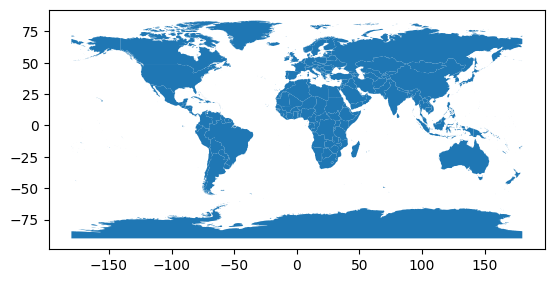

In [ ]:
pays.plot()

### Lecture du fichier des données

Les données se trouvent dans un fichier TSV qui était à l'intérieur de l'archive ZIP. Nous pouvons obtenir le chemin d'accès comme avant pour le fichier Shape, sauf que nous cherchons pour l'extension `.tsv`:

In [ ]:
wb_data_path = [df for df in data_files if df.endswith('.tsv')][0]
wb_data_path

'/root/.cache/pooch/1e46bb8437871d9c298d7e2d61618148-demographie-monde.zip.unzip/demographie-monde/wb_extract_development_indicators_2023/wb_extract_development_indicators_2023.tsv'

Nous pouvons lire le fichier avec Pandas. Il faut l'importer avant:

In [ ]:
import pandas as pd

In [ ]:
wb_data = pd.read_csv(wb_data_path, sep='\t')
print(wb_data.head())

     Country Name Country Code  \
0           World          WLD   
1     Afghanistan          AFG   
2         Albania          ALB   
3         Algeria          DZA   
4  American Samoa          ASM   

  2023 [YR2023] - Access to electricity (% of population) [EG.ELC.ACCS.ZS]  \
0                                                 ..                         
1                                                 ..                         
2                                                 ..                         
3                                                 ..                         
4                                                 ..                         

  2023 [YR2023] - Adjusted net national income (constant 2015 US$) [NY.ADJ.NNTY.KD]  \
0                                                 ..                                  
1                                                 ..                                  
2                                                 ..             

Nous pouvons maintenant faire une jointure par attribut des données aux DataFrame des pays. Pour ceci, nous devons identifier deux colonnes qui contiennent la même information.

Nous pouvons inspecter les colonnes des deux DataFrames:

In [ ]:
pays.columns.tolist()

['featurecla',
 'scalerank',
 'LABELRANK',
 'SOVEREIGNT',
 'SOV_A3',
 'ADM0_DIF',
 'LEVEL',
 'TYPE',
 'TLC',
 'ADMIN',
 'ADM0_A3',
 'GEOU_DIF',
 'GEOUNIT',
 'GU_A3',
 'SU_DIF',
 'SUBUNIT',
 'SU_A3',
 'BRK_DIFF',
 'NAME',
 'NAME_LONG',
 'BRK_A3',
 'BRK_NAME',
 'BRK_GROUP',
 'ABBREV',
 'POSTAL',
 'FORMAL_EN',
 'FORMAL_FR',
 'NAME_CIAWF',
 'NOTE_ADM0',
 'NOTE_BRK',
 'NAME_SORT',
 'NAME_ALT',
 'MAPCOLOR7',
 'MAPCOLOR8',
 'MAPCOLOR9',
 'MAPCOLOR13',
 'POP_EST',
 'POP_RANK',
 'POP_YEAR',
 'GDP_MD',
 'GDP_YEAR',
 'ECONOMY',
 'INCOME_GRP',
 'FIPS_10',
 'ISO_A2',
 'ISO_A2_EH',
 'ISO_A3',
 'ISO_A3_EH',
 'ISO_N3',
 'ISO_N3_EH',
 'UN_A3',
 'WB_A2',
 'WB_A3',
 'WOE_ID',
 'WOE_ID_EH',
 'WOE_NOTE',
 'ADM0_ISO',
 'ADM0_DIFF',
 'ADM0_TLC',
 'ADM0_A3_US',
 'ADM0_A3_FR',
 'ADM0_A3_RU',
 'ADM0_A3_ES',
 'ADM0_A3_CN',
 'ADM0_A3_TW',
 'ADM0_A3_IN',
 'ADM0_A3_NP',
 'ADM0_A3_PK',
 'ADM0_A3_DE',
 'ADM0_A3_GB',
 'ADM0_A3_BR',
 'ADM0_A3_IL',
 'ADM0_A3_PS',
 'ADM0_A3_SA',
 'ADM0_A3_EG',
 'ADM0_A3_MA',
 'ADM0_A3_PT

In [ ]:
wb_data.columns.tolist()

['Country Name',
 'Country Code',
 '2023 [YR2023] - Access to electricity (% of population) [EG.ELC.ACCS.ZS]',
 '2023 [YR2023] - Adjusted net national income (constant 2015 US$) [NY.ADJ.NNTY.KD]',
 '2023 [YR2023] - Adjusted net national income per capita (constant 2015 US$) [NY.ADJ.NNTY.PC.KD]',
 '2023 [YR2023] - Age dependency ratio, old (% of working-age population) [SP.POP.DPND.OL]',
 '2023 [YR2023] - Age dependency ratio, young (% of working-age population) [SP.POP.DPND.YG]',
 '2023 [YR2023] - Agricultural land (% of land area) [AG.LND.AGRI.ZS]',
 '2023 [YR2023] - Agricultural land (sq. km) [AG.LND.AGRI.K2]',
 '2023 [YR2023] - Agriculture, forestry, and fishing, value added (% of GDP) [NV.AGR.TOTL.ZS]',
 '2023 [YR2023] - Armed forces personnel (% of total labor force) [MS.MIL.TOTL.TF.ZS]',
 '2023 [YR2023] - Armed forces personnel, total [MS.MIL.TOTL.P1]',
 '2023 [YR2023] - Birth rate, crude (per 1,000 people) [SP.DYN.CBRT.IN]',
 '2023 [YR2023] - Births attended by skilled health st

Nous allons utiliser la colonne `WB_A3` du DataFrame des pays, et la colonne `Country Code` du DataFrame des données de la Banque mondiale.

Nous pouvons maintenant faire la jointure avec la fonction `merge`:

In [ ]:
pays_data = pays.merge(wb_data, left_on='WB_A3', right_on='Country Code', how='left')

### Calculer un indicateur d'âge

Nous allons calculer un indicateur d’âge, défini comme le rapport entre la population âgée (65 ans et plus) et la population jeune (0-14 ans), ou plus extactement le nombre de personnes âgées (65 ans et plus) pour 100 personnes jeunes (0 à 14 ans).

Le calcul est assez simple une fois que l'on a trouvé les noms des colonnes. Vu que les noms des colonnes ne sont vraiment pas simples, nous le gardons dans une variable:

In [ ]:
indic_vieux = '2023 [YR2023] - Population ages 65 and above, total [SP.POP.65UP.TO]'
indic_jeunes = '2023 [YR2023] - Population ages 0-14, total [SP.POP.0014.TO]'

Avant de procéder au calcul, nous devons nous assurer que les valeurs sont numériques et que les valeurs non numériques sont des `NaN` (avec `errors = 'coerce'`):

In [ ]:
pays_data[indic_vieux] = pd.to_numeric(pays_data[indic_vieux], errors='coerce')
pays_data[indic_jeunes] = pd.to_numeric(pays_data[indic_jeunes], errors='coerce')

Ensuite le calcul en tant que tel:

In [ ]:
pays_data['indic_age'] = pays_data[indic_vieux] / pays_data[indic_jeunes] * 100

Vérifier le calcul:

In [ ]:
pays_data['indic_age']

,indic_age
0,8.182359
1,4.166559
2,6.780921
3,43.005289
4,32.965688
...,...
237,5.590231
238,NaN
239,NaN
240,112.228705


### Créer des classes et faire le décompte des personnes

Nous allons maintenant diviser les pays en 5 classes selon l'indicateur d'âge. chaque classe aura à peu près le même nombre de pays. Nous utilisons la fonction `qcut` de Pandas pour cela. Consultez la documentation Pandas pour en savoir plus:

In [ ]:
pays_data['indic_age_cls'] = pd.qcut(pays_data['indic_age'], q=5, labels=False)

Et inspecter le résultat:

In [ ]:
print(pays_data[['NAME', 'indic_age_cls']].head())

        NAME  indic_age_cls
0   Zimbabwe            0.0
1     Zambia            0.0
2      Yemen            0.0
3    Vietnam            2.0
4  Venezuela            2.0


Regardons le résultat sur une carte rapide:

<Axes: >

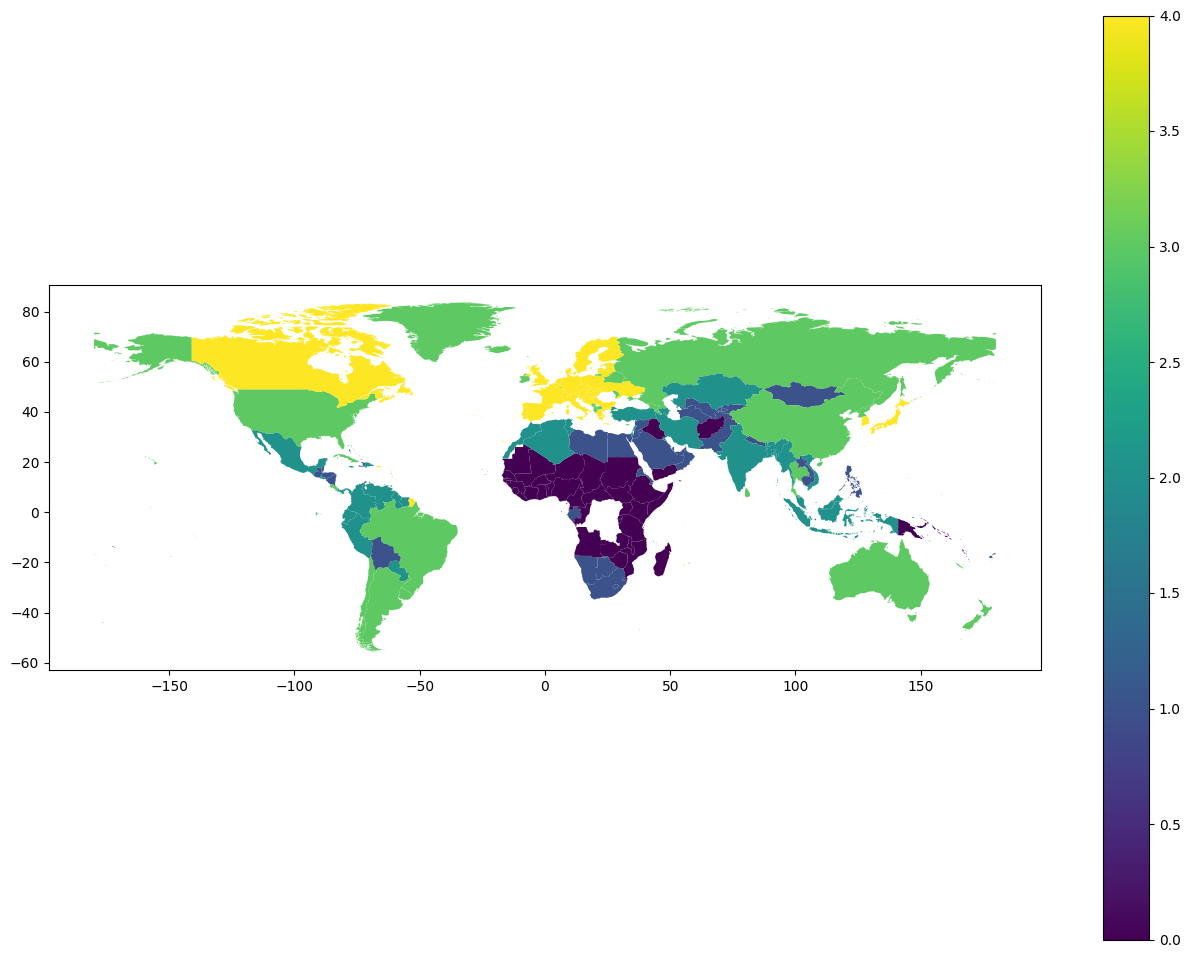

In [ ]:
pays_data.plot(
    column = 'indic_age_cls',
    cmap = 'viridis',
    legend = True,
    figsize = (16, 12)
)

Nous avons certainement vu des meilleures cartes... mais elle fait l'affaire pour le moment. L'indicateur d'âge représente le ratio vieux / jeunes, et plus l'indicateur est élevé, plus il y a de personnes âgées par rapport aux jeunes. Il représente donc une facette du veillissement de la population, avec surtout les pays occidentaux ayant une valeur élevée.

Nous pouvons maintenant compter combien de personnes appartiennent à quelle classe de l'indicateur d'âge. Cette opération d'agrégation s'appelle un **«group by»** et on groupe toutes les entités avec la même valeur. Ensuite, on peut calculer des statistiques sur ces groupes, en l'occurrence la somme:

In [ ]:
col_pop = '2023 [YR2023] - Population, total [SP.POP.TOTL]'
pays_data[col_pop] = pd.to_numeric(pays_data[col_pop], errors='coerce')
pop_par_classe = pays_data.groupby('indic_age_cls')[col_pop].sum()

In [ ]:
pop_par_classe

,"2023 [YR2023] - Population, total [SP.POP.TOTL]"
indic_age_cls,
0.0,1.194982e+09
1.0,8.251452e+08
2.0,2.685410e+09
3.0,2.379984e+09
4.0,7.809146e+08


Nous pouvons maintenant faire un graphique avec Matplotlib:

In [ ]:
import matplotlib.pyplot as plt

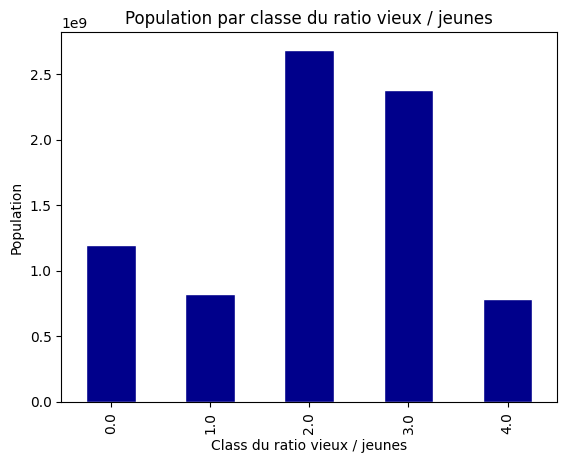

In [ ]:
pop_par_classe.plot(kind="bar", color="darkblue", edgecolor="white")
plt.title("Population par classe du ratio vieux / jeunes")
plt.xlabel("Class du ratio vieux / jeunes")
plt.ylabel("Population")
plt.show()

Pour finir cette partie, nous écrivons le jeu de données final dans un fichier Parquet:

In [ ]:
pays_data.to_file('pays_data.gpkg', driver='GPKG', layer='pays_data')

## Partie 2: Analyse des données OpenStreetMap d'Estonie

Les données OpenStreetMap contiennent beaucoup de données que nous pouvons exploiter pour différentes analyses. Nous allons montrer quelques exemples concrets dans cette partie.

Il faut noter que les données OpenStreetMap sont des données qui sont générées par les utilisateurs et elles ne sont pas partout complètes au même degré. Dans certaines régions, l'administration publique contribue également aux données. Ou certaines entreprises utilisent les données OpenStreetMap dans leurs produits et aident à compléter la base de données (p.ex. Facebook, Apple, Microsoft utilisent tous les données OSM dans leur cartes).

Par ailleurs, si vous constatez que les données sur OpenStreetMap ne sont pas complètes, n'hésitez pas à les compléter sur [osm.org](https://osm.org). Àprès connexion, il y a un bouton «Éditer» qui devient disponible...

### Les bancs publics d'Estonie

Pour commencer, nous pouvons télécharger les données OpenStreetMap d'Estonie depuis l'URL suivante: [https://files.swisscarto.ch/geoinf1/analyse-estonie.zip](https://files.swisscarto.ch/geoinf1/analyse-estonie.zip).

L'archive ZIP contient également des régions administratives d'Estonie. Ces données viennent de l'Office statistique d'Estonie et contiennent également une information sur la population par région.

Nous pouvons à nouveau utiliser Pooch pour télécharger l'archive et ensuite la décompresser:

In [ ]:
data_ee = pooch.retrieve(
    url = 'https://files.swisscarto.ch/geoinf1/analyse-estonie.zip',
    known_hash = None,
    processor = pooch.Unzip()
)

SHA256 hash of downloaded file: a700fb1624f60d8cd82589078544fc57fbd5ae3a5046a95adc6a72622e531a77
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
Unzipping contents of '/root/.cache/pooch/b6cfe6a45ccd34fb337f2d7ce73792f4-analyse-estonie.zip' to '/root/.cache/pooch/b6cfe6a45ccd34fb337f2d7ce73792f4-analyse-estonie.zip.unzip'


Nous cherchons le fichier avec les points d'intérêts. Nous allons extraire les bancs publics depuis ce jeu de données (oui, oui, cette information y est) pour ensuite faire le décompte.

Le fichier des points d'intérêts est un fichier Shape (avec extension `.shp` et qui contient le mot `pois`:

In [ ]:
pois_shp_path = [f for f in data_ee if f.endswith('.shp') and 'pois' in f][0]
pois_shp_path

'/root/.cache/pooch/b6cfe6a45ccd34fb337f2d7ce73792f4-analyse-estonie.zip.unzip/analyse-estonie/osm/gis_osm_pois_free_1.shp'

On peut maintenant lire le fichier avec GeoPandas:

In [ ]:
pois_ee = gpd.read_file(pois_shp_path)
print(pois_ee.head())

     osm_id  code          fclass                name  \
0  21619742  2733  archaeological           Vallimägi   
1  26860115  2422       camp_site           Annimatsi   
2  28916615  2304             pub               Virma   
3  28916663  2005     post_office  Rakvere postkontor   
4  29168843  2009      courthouse       Viru Maakohus   

                    geometry  
0  POINT (26.35243 59.34633)  
1  POINT (26.42806 58.03917)  
2  POINT (26.35552 59.35068)  
3   POINT (26.36409 59.3487)  
4  POINT (26.35767 59.35048)  


Les bancs publics ont la valeur `bench` pour la colonne `fclass`. On peut les extraire avec une expression un peu bizarre mais assez simple au final:

In [ ]:
bancs = pois_ee[pois_ee['fclass'] == 'bench']
print(bancs.head())

          osm_id  code fclass  name                   geometry
78     294275681  2902  bench  None  POINT (24.53784 59.37929)
79     294275682  2902  bench  None  POINT (24.53791 59.37926)
228    380274393  2902  bench  None  POINT (24.39248 58.38736)
1261   735127577  2902  bench  None  POINT (25.62843 59.27479)
2229  1103556416  2902  bench  None  POINT (25.88451 59.04057)


Nous pouvons décomposer un peu cette ligne de code. La partie `pois_ee['fclass']` est la colonne qui contient toutes les valeurs de l'attribut `fclass`:

In [ ]:
pois_ee['fclass']

,fclass
0,archaeological
1,camp_site
2,pub
3,post_office
4,courthouse
...,...
38170,bench
38171,toilet
38172,cafe
38173,atm


On peut demander à Pandas si ces valeurs sont égales à `bench`:

In [ ]:
pois_ee['fclass'] == 'bench'

,fclass
0,False
1,False
2,False
3,False
4,False
...,...
38170,True
38171,False
38172,False
38173,False


Ceci évalue cette comparaison pour chaque entité dans le DataFrame `pois_ee`, et retourne soit `True` soit `False`. Nous pouvons utiliser ce mécanisme pour filtrer les entités du DataFrame, en passant une sorte de liste avec des `True` et `False`. Les entités avec `True` sont retenues, les autres écartées.

On peut même enregistrer la condition dans une variable et écrire la même instruction que plus haut en deux lignes:

In [ ]:
critere = pois_ee['fclass'] == 'bench'
bancs = pois_ee[critere]
print(bancs.head())

          osm_id  code fclass  name                   geometry
78     294275681  2902  bench  None  POINT (24.53784 59.37929)
79     294275682  2902  bench  None  POINT (24.53791 59.37926)
228    380274393  2902  bench  None  POINT (24.39248 58.38736)
1261   735127577  2902  bench  None  POINT (25.62843 59.27479)
2229  1103556416  2902  bench  None  POINT (25.88451 59.04057)


### Les régions d'Estonie

Nous pouvons maintenant charger la couche des régions administratives depuis le Geopackage:

In [ ]:
regions_ee_path = [f for f in data_ee if f.endswith('.gpkg')][0]
regions_ee_path

'/root/.cache/pooch/b6cfe6a45ccd34fb337f2d7ce73792f4-analyse-estonie.zip.unzip/analyse-estonie/kontur_boundaries_ee_20230628.gpkg'

Les fichiers Geopackage peuvent contenir plusieurs couches vectorielles. Si le Geopackage n'a qu'une seule couche, GeoPandas pourra la lire sans indiquer le nom. Mais avec plus d'une couche, il faudra spécifier le nom. Seulement, comment connaître le nom de la couche? Pour cela, nous pouvons utiliser un autre module Python: `pyogrio` (nous avons déjà rencontré `ogr` dans `ogr2ogr`, c'est bien le même). `pyogrio` est utilisé par GeoPandas et donc déjà disponible sur notre système. Il suffit de l'importer:

In [ ]:
import pyogrio

Ensuite on peut afficher la liste des couches à l'intérieur du GeoPackage:

In [ ]:
pyogrio.list_layers(regions_ee_path)

array([['boundaries', 'Polygon']], dtype=object)

In [ ]:
regions = gpd.read_file(regions_ee_path,  layer='boundaries')
print(regions.head())

   admin_level osm_admin_level           name      name_en  population  hasc  \
0            7               7  Viljandi vald         None     12987.0  None   
1            7               7      Saku vald  Saku Parish      5686.0  None   
2            7               7     Anija vald         None      4424.0  None   
3            7               7     Rõuge vald         None      7124.0  None   
4            7               7    Maardu linn       Maardu      3531.0  None   

                                            geometry  
0  MULTIPOLYGON (((25.30726 58.39193, 25.30734 58...  
1  MULTIPOLYGON (((24.52208 59.27347, 24.5225 59....  
2  MULTIPOLYGON (((25.16759 59.34274, 25.16761 59...  
3  MULTIPOLYGON (((26.44342 57.65159, 26.446 57.6...  
4  MULTIPOLYGON (((24.91462 59.47382, 24.91635 59...  


### Le nombre de bancs publics par région et par habitant

Combien de bancs publics il y a par région? Pour cela, il faut savoir dans quelle région se trouve chacun des bancs. Dans un SIG, une telle opération se fait à l'aide d'une **jointure spatiale**. Et avec GeoPandas, une jointure spatiale n'est pas compliquée, la fonction `sjoin` s'en occupe. Voici comment nous pouvons joindre les informations sur les régions à la couche des bancs:

In [ ]:
bancs_avec_region = gpd.sjoin(bancs, regions, how="inner", predicate="within")
bancs_avec_region.head()

,osm_id,code,fclass,name_left,geometry,index_right,admin_level,osm_admin_level,name_right,name_en,population,hasc
78,294275681,2902,bench,None,POINT (24.53784 59.37929),69,7,7,Saue vald,None,11537.0,None
79,294275682,2902,bench,None,POINT (24.53791 59.37926),69,7,7,Saue vald,None,11537.0,None
228,380274393,2902,bench,None,POINT (24.39248 58.38736),43,7,7,Pärnu linn,None,13820.0,None
1261,735127577,2902,bench,None,POINT (25.62843 59.27479),2,7,7,Anija vald,None,4424.0,None
2229,1103556416,2902,bench,None,POINT (25.88451 59.04057),47,7,7,Järva vald,None,8066.0,None


L'information sur la région administrative est du coup dans `name_right`. Il suffit de compter le nombre de fois que chaque région apparaît dans la liste et on connaît le nombre de bancs dans chaque région...

Techniquement, il s'agit ici d'une agrégation de type **«group by»** (on regroupe les bancs selon les régions), et ensuite on fait le décompte (le nombre):

In [ ]:
bancs_decompte = bancs_avec_region.groupby('name_right').size()
bancs_decompte

,0
name_right,
Alutaguse vald,12
Anija vald,11
Antsla vald,10
Elva vald,47
Haapsalu linn,92
...,...
Viru-Nigula vald,10
Vormsi vald,6
Väike-Maarja vald,5


Cette combinaison entre jointure spatiale et agrégation de type «group by» est très fréquent dans les analyses SIG. QGIS possède d'ailleurs un outil qui combine les deux étapes ensemble, il s'agit de l'outil *«Joindre les attributs par localisation (résumé)»*, qui est une variante de la jointure spatiale.

Par contre, nous devons encore joindre notre décompte à la couche des régions, dans une nouvelle colonne:

In [ ]:
regions['n_bancs'] = regions['name'].map(bancs_decompte)
regions.head()

,admin_level,osm_admin_level,name,name_en,population,hasc,geometry,n_bancs
0,7,7,Viljandi vald,None,12987.0,None,"MULTIPOLYGON (((25.30726 58.39193, 25.30734 58...",77.0
1,7,7,Saku vald,Saku Parish,5686.0,None,"MULTIPOLYGON (((24.52208 59.27347, 24.5225 59....",49.0
2,7,7,Anija vald,None,4424.0,None,"MULTIPOLYGON (((25.16759 59.34274, 25.16761 59...",11.0
3,7,7,Rõuge vald,None,7124.0,None,"MULTIPOLYGON (((26.44342 57.65159, 26.446 57.6...",71.0
4,7,7,Maardu linn,Maardu,3531.0,None,"MULTIPOLYGON (((24.91462 59.47382, 24.91635 59...",136.0


Nous pouvons maintenant calculer le nombre de bancs par 1000 habitants et en faire une carte rapide:

In [ ]:
regions['n_bancs_par_1k'] = regions['n_bancs'] / (regions['population'] / 1000)
regions[['name', 'n_bancs', 'n_bancs_par_1k']].head()

,name,n_bancs,n_bancs_par_1k
0,Viljandi vald,77.0,5.929006
1,Saku vald,49.0,8.617657
2,Anija vald,11.0,2.486438
3,Rõuge vald,71.0,9.966311
4,Maardu linn,136.0,38.516001


<Axes: >

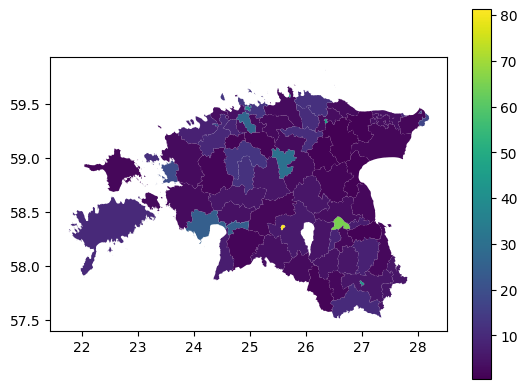

In [ ]:
regions.plot(
    column = 'n_bancs_par_1k',
    cmap = 'viridis',
    legend = True
)

Avec un peu de chance nous avons trouvé les régions les plus touristiques d'Estonie et nous pouvons planifier nos vacances. Autrement, il y aura au moins assez de bancs pour se reposer.

### La longueur du rail par région

Nous pouvons aussi déterminer la longueur du rail par région à l'aide des données OSM. Commençons par charger la couche des trains:

In [ ]:
rail_shp_path = [f for f in data_ee if f.endswith('.shp') and 'railways' in f][0]
rail_shp_path

'/root/.cache/pooch/b6cfe6a45ccd34fb337f2d7ce73792f4-analyse-estonie.zip.unzip/analyse-estonie/osm/gis_osm_railways_free_1.shp'

Lire les données:

In [ ]:
rails = gpd.read_file(rail_shp_path)

Pour déterminer la région pour les lignes des trains, il faut découper les lignes aux limites des régions. L'opération SIG d'intersection permet de faire cela et combine en même temps les attributs des deux couches impliquées. Dans GeoPandas, nous utilisons la fonction `overlay`:

In [ ]:
rails_par_region = gpd.overlay(rails, regions, how="intersection")

<ipython-input-45-acd9a62df9c8>:1: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  rails_par_region = gpd.overlay(rails, regions, how="intersection")


Nous pouvons encore ajouter la longueur des trains sur la base des lignes. Notez que cette opération dépend du système de coordonnées. Dans notre cas, nous avons un jeu de données en WGS84. Un système de coordonnées géographique en latitude/longitude ne se prête pas à un tel calcul. Nous allons projeter la couche d'abord dans un système de coordonnées UTM (la zone 35N correspond à l'Estonie, le code EPSG est 32635):

In [ ]:
rails_par_region_utm = rails_par_region.to_crs(epsg=32635)

Pour les opérations sur les géométries, on peut passer par l'attribut `geometry` du DataFrame GeoPandas. **Ceci nous permet de calculer des choses comme la longueur, la superficie ou le centroïde.**

In [ ]:
rails_par_region_utm['longueur'] = rails_par_region_utm.geometry.length

Et nous pouvons à nouveau faire une agrégation de type *«group by»* et calculer la somme. Il faut encore connaître le nom de la colonne qui contient le nom de la région:

In [ ]:
rails_par_region_utm.head()

,osm_id,code,fclass,name_1,layer,bridge,tunnel,admin_level,osm_admin_level,name_2,name_en,population,hasc,n_bancs,n_bancs_par_1k,geometry,longueur
0,3934073,6101,rail,None,0,F,F,7,7,Kadrina vald,None,2832.0,None,30.0,10.593220,"LINESTRING (452658.208 6578127.7, 453119.563 6...",4714.793317
1,3934073,6101,rail,None,0,F,F,7,7,Rakvere vald,None,3179.0,None,10.0,3.145643,"LINESTRING (457337.23 6578664.481, 457391.856 ...",4311.226770
2,3997258,6101,rail,None,0,F,F,7,7,Tapa vald,None,5614.0,None,62.0,11.043819,"LINESTRING (441034.556 6570108.031, 441125.881...",808.697190
3,4037625,6101,rail,None,0,F,F,7,7,Rakvere linn,None,2666.0,None,127.0,47.636909,"LINESTRING (462299.411 6579723.309, 462431.742...",783.458584
4,4037625,6101,rail,None,0,F,F,7,7,Rakvere vald,None,3179.0,None,10.0,3.145643,"LINESTRING (461553.74 6579563.205, 461811.494 ...",762.665633


In [ ]:
rail_longueurs = rails_par_region_utm.groupby('name_2')['longueur'].sum()
rail_longueurs.head()

,longueur
name_2,
Alutaguse vald,24563.534651
Anija vald,70664.036293
Antsla vald,16020.806355
Elva vald,24785.511269
Haapsalu linn,2351.591157


Et nous pouvons ajouter l'information au GeoDataFrame sous forme d'une nouvelle colonne:

In [ ]:
regions["rail_longueur"] = regions["name"].map(rail_longueurs)
regions.head()

,admin_level,osm_admin_level,name,name_en,population,hasc,geometry,n_bancs,n_bancs_par_1k,rail_longueur
0,7,7,Viljandi vald,None,12987.0,None,"MULTIPOLYGON (((25.30726 58.39193, 25.30734 58...",77.0,5.929006,10121.266885
1,7,7,Saku vald,Saku Parish,5686.0,None,"MULTIPOLYGON (((24.52208 59.27347, 24.5225 59....",49.0,8.617657,18023.618075
2,7,7,Anija vald,None,4424.0,None,"MULTIPOLYGON (((25.16759 59.34274, 25.16761 59...",11.0,2.486438,70664.036293
3,7,7,Rõuge vald,None,7124.0,None,"MULTIPOLYGON (((26.44342 57.65159, 26.446 57.6...",71.0,9.966311,1459.614624
4,7,7,Maardu linn,Maardu,3531.0,None,"MULTIPOLYGON (((24.91462 59.47382, 24.91635 59...",136.0,38.516001,79907.784848


Par ailleurs, l'unité de la longueur est la même que celle du système de coordonnées. Pour UTM, ce sont des mètres.